# Debugging a pipeline

In [1]:
%matplotlib inline

`creme` encourages users to make use of pipelines. The biggest pain point of pipelines is that it can be hard to understand what's happening to the data, especially when the pipeline is complex. Fortunately the `Pipeline` class has a `debug_one` method that can help out.

Let's look at a fairly complex pipeline for predicting the number of bikes in 5 bike stations from the city of Toulouse. It doesn't matter if you understand the pipeline or not; the point of this notebook is to learn how to introspect a pipeline.

In [2]:
import datetime as dt
from creme import compose
from creme import datasets
from creme import feature_extraction
from creme import linear_model
from creme import metrics
from creme import preprocessing
from creme import stats
from creme import stream


X_y = datasets.Bikes()
X_y = stream.simulate_qa(X_y, moment='moment', delay=dt.timedelta(minutes=30))

def add_time_features(x):
    return {
        **x,
        'hour': x['moment'].hour,
        'day': x['moment'].weekday()
    }

model = add_time_features
model |= (
    compose.Select('clouds', 'humidity', 'pressure', 'temperature', 'wind') +
    feature_extraction.TargetAgg(by=['station', 'hour'], how=stats.Mean()) +
    feature_extraction.TargetAgg(by='station', how=stats.EWMean())
)
model |= preprocessing.StandardScaler()
model |= linear_model.LinearRegression()

metric = metrics.MAE()

questions = {}

for i, x, y in X_y:
    # Question
    is_question = y is None
    if is_question:
        y_pred = model.predict_one(x)
        questions[i] = y_pred
    
    # Answer
    else:
        metric.update(y, questions[i])
        model = model.fit_one(x, y)
    
        if i >= 30000 and i % 30000 == 0:
            print(i, metric)

30000 MAE: 2.193126
60000 MAE: 2.249468
90000 MAE: 2.288453
120000 MAE: 2.265392
150000 MAE: 2.267563
180000 MAE: 2.282636


We can start by looking at what the pipeline looks by drawing it.

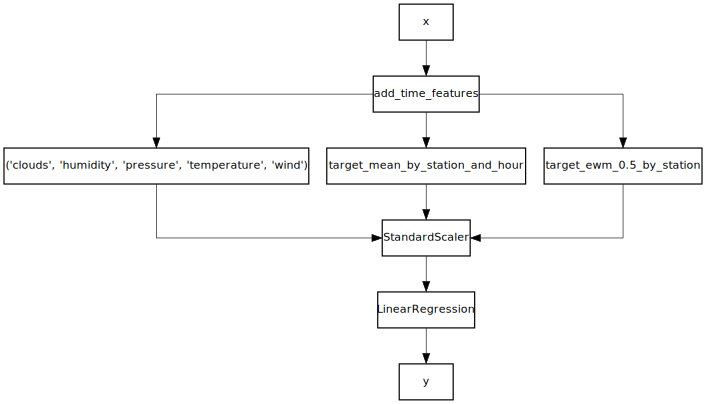

In [3]:
model.draw()

As mentionned above the `Pipeline` class has a `debug_one` method. You can use this at any point you want to visualize what happen to an input `x`. For example, let's see what happens to the last seen `x`.

In [4]:
model.debug_one(x)

0. Input
--------
clouds: 88 (int)
description: overcast clouds (str)
humidity: 84 (int)
moment: 2016-10-05 09:57:18 (datetime)
pressure: 1,017.34000 (float)
station: pomme (str)
temperature: 17.45000 (float)
wind: 1.95000 (float)

1. add_time_features
--------------------
clouds: 88 (int)
day: 2 (int)
description: overcast clouds (str)
hour: 9 (int)
humidity: 84 (int)
moment: 2016-10-05 09:57:18 (datetime)
pressure: 1,017.34000 (float)
station: pomme (str)
temperature: 17.45000 (float)
wind: 1.95000 (float)

2. Transformer union
--------------------
    2.0 ('clouds', 'humidity', 'pressure', 'temperature', 'wind')
    -------------------------------------------------------------
    clouds: 88 (int)
    humidity: 84 (int)
    pressure: 1,017.34000 (float)
    temperature: 17.45000 (float)
    wind: 1.95000 (float)

    2.1 target_mean_by_station_and_hour
    -----------------------------------
    target_mean_by_station_and_hour: 7.89396 (float)

    2.2 target_ewm_0.5_by_station
    

The pipeline does quite a few things, but using `debug_one` shows what happens step by step. This is really useful for checking that the pipeline is behaving as you're expecting it too. Remember that you can `debug_one` whenever you wish, be it before, during, or after training a model.